<a href="https://colab.research.google.com/github/karsarobert/Machine_learning_2024/blob/main/07/PTE_ML7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A mesterséges intelligencia matematikai alapjai gyakorlat
# PTE Gépi tanulás

## 7. Gyakorlat: Döntési fák, véletlen erdők, boosting, gridsearch
### 2024. március 19.

# Hiperparaméterek hangolása gridsearch segítségével

In [37]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('https://raw.githubusercontent.com/karsarobert/Machine_Learning_2024/main/diabetes.csv') # adatok betöltése

y = df.label #X,y beállítása
X= df.drop(['label'], axis = 1)


| Magyar | Angol | Jelentés | Típus |
|---|---|---|---|
| Terhes | Pregnancies | Terhesség ideje (hónapokban) | Szám |
| Vércukor | Glucose | Vércukor 2 órás OGTT vizsgálat után (mg/dL) | Szám |
| Vérnyomás | BloodPressure | Diastolés vérnyomás (Hgmm) | Szám |
| Triceps bőrredő vastagság | SkinThickness | Triceps bőrredő vastagsága (mm) | Szám |
| Testtömeg-index | BMI | Testtömeg-index (kg/m^2) | Szám |
| Családi kórtörténet | DiabetesPedigreeFunction | Családban előforduló cukorbetegség (0=nincs, 1=van) | Kategória |
| Életkor | Age | Életkor (években) | Szám |
| Inzulin | Insulin | 2 órás OGTT vizsgálat során mért inzulin koncentráció (µU/mL) | Szám |
| C-peptid | Cpeptide | 2 órás OGTT vizsgálat során mért C-peptid koncentráció (ng/mL) | Szám |
| Cukorbetegség | Outcome | Cukorbetegség diagnózisa (0=nem, 1=igen) | Kategória |

#Crossvalidation, keresztvalidáció
![](https://miro.medium.com/max/1400/0*W7JGxNLP1Jvlz3Hu.png)

#Gridsearch

![](https://i0.wp.com/sqlrelease.com/wp-content/uploads/2021/08/An-introduction-to-GridSearchCV-and-RandomizedSearchCV-Image.jpg?w=954&ssl=1)

In [38]:
from sklearn.model_selection import GridSearchCV # paraméterek hangolása
rf_clf = DecisionTreeClassifier() # a döntési fa osztályozó
params_grid = {"max_depth" : [3,4,5,6,7,8,9,10, None],
              "min_samples_split": [2, 3, 10, 20],
              } # döntési fához tartozó hiperparaméterek felsorolása egy dictionary be
grid_search = GridSearchCV(rf_clf, params_grid,
                           n_jobs=-1, cv=5, scoring='accuracy') #grid search beállítása
grid_search.fit(X, y) #illesztés

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
                         'min_samples_split': [2, 3, 10, 20]},
             scoring='accuracy')

In [39]:
grid_search.best_params_ # a megadott paraméterekből a legjobb találat

{'max_depth': 5, 'min_samples_split': 3}

In [40]:
from sklearn.metrics import accuracy_score
cvrf_clf = grid_search.best_estimator_ # a legjobb modell kiválasztása
grid_search.best_score_ # a legjobb modell pontossága

0.7487649605296663

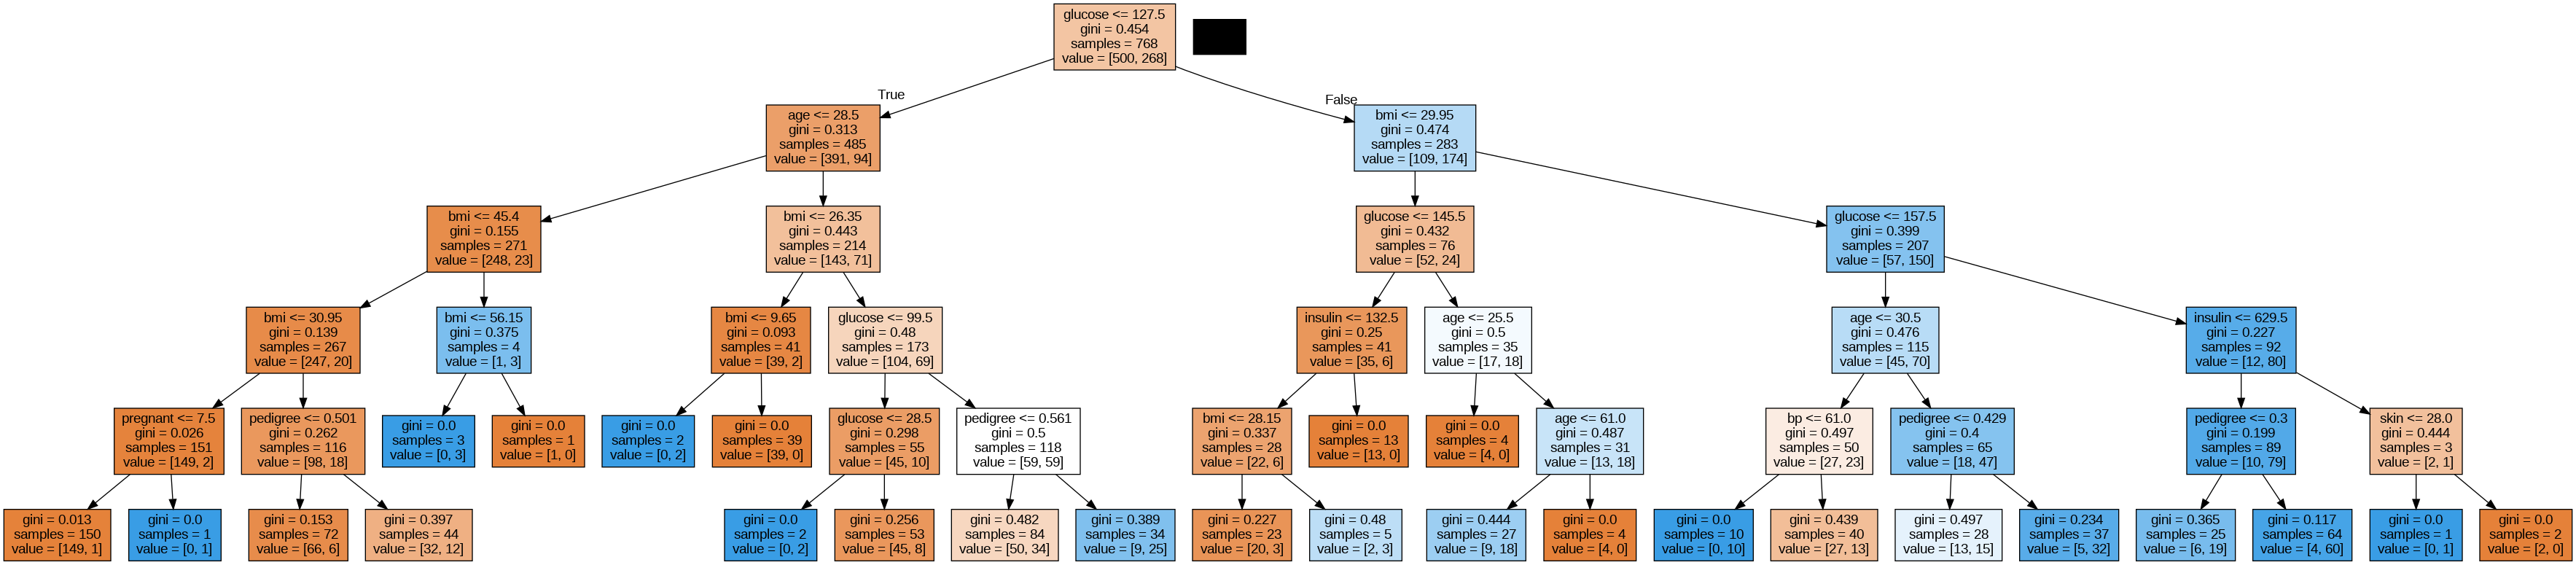

In [41]:
from sklearn import tree
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(cvrf_clf, out_file=None,feature_names= X.columns, filled = True) # a legjobb modell ábrázolása
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

#Ensemble (együttes) módszerek
##Majority voting, többségi szavazás (párhuzamosítható feladat)

![](https://www.researchgate.net/publication/324014302/figure/fig2/AS:644424015040514@1530654066950/Majority-voting-algorithm.png)

In [42]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import VotingClassifier # többségi szavazás
from sklearn.linear_model import LogisticRegression

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/Machine_Learning_2024/main/diabetes.csv") # adatok betöltése

y = df.label #X,y beállítása
X = df.drop(['label'], axis = 1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1) # első felosztás train, teszt halmazokra

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=1) # második felosztás a train halmazt tovább osztjuk train és valid halmazokra

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0]) # az egyes halmazok elemszámainak kiiratása

# definiálunk 3 osztályozót
clf1 = DecisionTreeClassifier(random_state=1, max_depth=None)
# max_depth=None a csomópontok addig bővülnek, amíg az összes levél tiszta nem lesz, vagy amíg az összes levél kevesebb mint min_samples_split mintát tartalmaz.
clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf3 = LogisticRegression(solver='lbfgs', max_iter=1000)

clf1.fit(X_train, y_train) # az egyes modellek (clf1-clf3) illesztését csak azért végezzük el, hogy lássuk az eredményeket!
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
eclf = VotingClassifier(estimators=[   # együttes osztályozó létrehozása
        ('DTC1', clf1), ('DTC2', clf2), ('LR3', clf3)],
        voting='hard', weights=[1,1,1]) # voting paraméter lehet hard és soft
        # a soft voting nem a döntés szerinti osztályokkal dolgozik haenm a valószínűségi kimenetekkel!


eclf = eclf.fit(X_train, y_train) # együttes osztályozó illesztése
print("clf1 Accuracy: %0.4f" % clf1.score(X_val, y_val))
print("clf2 Accuracy: %0.4f" % clf2.score(X_val, y_val))
print("clf3 Accuracy: %0.4f" % clf3.score(X_val, y_val))
print("Ensemble Accuracy: %0.4f" % eclf.score(X_val, y_val))

Train/Valid/Test sizes: 491 123 154
clf1 Accuracy: 0.6667
clf2 Accuracy: 0.7236
clf3 Accuracy: 0.7480
Ensemble Accuracy: 0.7317


#Bagging (bootstrap aggregating)

##Bootstrap sampling
![](http://rasbt.github.io/mlxtend/user_guide/evaluate/BootstrapOutOfBag_files/bootstrap_concept.png)

![](https://static.packt-cdn.com/products/9781787125933/graphics/B07030_07_06.jpg)

![](https://datavedas.com/wp-content/uploads/2018/04/image003.jpg)

In [43]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import BaggingClassifier

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/Machine_Learning_2024/main/diabetes.csv") # adatok betöltése

y = df.label #X,y beállítása
X = df.drop(['label'], axis = 1)


X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1) # első felosztás train, teszt halmazokra

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.2, random_state=1) # második felosztás a train halmazt tovább osztjuk train és valid halmazokra

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0])

tree = DecisionTreeClassifier(criterion='entropy', # döntési fa osztályozó létrehozása
                              random_state=1,
                              max_depth=None)


bag = BaggingClassifier(base_estimator=tree, # bagging osztályozó létrehozása
                        n_estimators=500, # becslők száma
                        oob_score=True, # mérjük-e a teszt halmaz eredményeit
                        bootstrap=True, # bootstrap alkalmazása
                        n_jobs=1, # hány szálon fusson
                        random_state=1)

bag.fit(X_train, y_train)

print("OOB Accuracy: %0.2f" % bag.oob_score_) #zsákon kívüli adatokra (test set) vonatkozó pontosság!
print("Test Accuracy: %0.2f" % bag.score(X_test, y_test))

Train/Valid/Test sizes: 491 123 154


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


OOB Accuracy: 0.75
Test Accuracy: 0.79


In [44]:
tree = DecisionTreeClassifier(criterion='entropy', # egy fa pontossága
                              random_state=1,
                              max_depth=None)

tree.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % tree.score(X_test, y_test))

Test Accuracy: 0.73


#Boosting eljárások

![](https://www.statology.org/wp-content/uploads/2020/11/boosting1-691x1024.png)

#AdaBoosting

Az adaptív boost ing (más néven AdaBoost) az egyik leggyakrabban használt boosting ensemble módszer. Az alkalmazkodó boosting egyesíti ( fellendíti ) a gyenge tanulókat, és erős tanulóvá alakítja.

![](https://www.researchgate.net/profile/Mustafa-Fayez/publication/353826737/figure/fig4/AS:1055764118515712@1628725189980/4-Ada-Boost-classifier-steps-49.jpg)

Az 1. osztályozó osztályozza a pontokat (1. kép). Vannak olyan pontok (kék pontok), amelyeket rosszul osztályoznak.

A rosszul besorolt ​​pontok nagyobb súlyt kapnak, és a helyesen besorolt ​​pontok súlya csökken. Egy új osztályozó olyan új képzési adatkészlettel van betanítva, amely több súlyt rendel a rosszul osztályozott pontokhoz és kisebb súlyokat a helyesen osztályozott pontokhoz (így adaptív újramintavételezés ).

Nézze meg a 2. képet, ahol a rosszul besorolt ​​pontok nagyobb súlyt kaptak, ami nagyobb +-al vagy -al van ábrázolva, és a helyesen osztályozott pontok mérete csökkent. Az új osztályozó ismét néhány pont (3 kék pont) hibás besorolását eredményezi.

A 2. osztályozó által besorolt ​​rosszul besorolt ​​pontok nagyobb súlyt kapnak, a helyesen besorolt ​​pontok pedig kisebb súlyt kapnak (csökkentett méret).

A 3. osztályozó új képzési adatkészletekkel újraképződik, minden egyes adatpont súlyozásával. Vessen egy pillantást a 3. képre.

Végül az ensemble adaptív boosting osztályozó három osztályozó összeállításával készül, amelyeket az adaptív újramintavételezés eredményeként létrehozott különböző képzési adatkészletek felhasználásával állítottak össze / illesztettek / betanítottak. A 4. kép, amely az adaptív boost (AdaBoost) osztályozót ábrázolja, amelyet három osztályozó összeállításával jött létre.

In [45]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier

import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/karsarobert/Machine_Learning_2024/main/diabetes.csv") # adatok betöltése

y = df.label #X,y beállítása
X = df.drop(['label'], axis = 1)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0])

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)


boost = AdaBoostClassifier(estimator=tree,
                           n_estimators=500,
                           algorithm='SAMME', #A SAMME egy multiklaszszifikációs boosting algoritmus
                           random_state=1)

boost.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))

Train/Valid/Test sizes: 432 144 192
Test Accuracy: 0.81


In [46]:
len(boost.estimator_weights_)

500

#Gradient boosting

![](https://www.researchgate.net/profile/Maria-Peraita-Adrados/publication/326379229/figure/fig5/AS:647978477948928@1531501516288/A-simple-example-of-visualizing-gradient-boosting.png)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier


boost = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=8,
    random_state=1)

boost.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))

Test Accuracy: 0.77


#Random forest classifier
![](https://miro.medium.com/max/1400/1*hmtbIgxoflflJqMJ_UHwXw.jpeg)

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # adatok standardizálása 0 átlag 1 szórás
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [49]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=100,
                                random_state=1)

forest.fit(X_train_std, y_train)

print("Test Accuracy: %0.2f" % forest.score(X_test_std, y_test))

Test Accuracy: 0.78


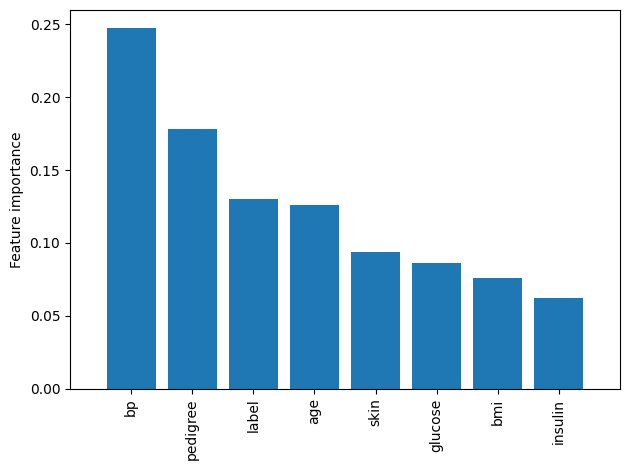

In [50]:
import numpy as np
import matplotlib.pyplot as plt

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

feat_labels = df.columns[1:]
plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.savefig('feature-importance.pdf', dpi=300)
plt.show()

| Magyar | Angol | Jelentés | Típus |
|---|---|---|---|
| Terhes | Pregnancies | Terhesség ideje (hónapokban) | Szám |
| Vércukor | Glucose | Vércukor 2 órás OGTT vizsgálat után (mg/dL) | Szám |
| Vérnyomás | BloodPressure | Diastolés vérnyomás (Hgmm) | Szám |
| Triceps bőrredő vastagság | SkinThickness | Triceps bőrredő vastagsága (mm) | Szám |
| Testtömeg-index | BMI | Testtömeg-index (kg/m^2) | Szám |
| Családi kórtörténet | DiabetesPedigreeFunction | Családban előforduló cukorbetegség (0=nincs, 1=van) | Kategória |
| Életkor | Age | Életkor (években) | Szám |
| Inzulin | Insulin | 2 órás OGTT vizsgálat során mért inzulin koncentráció (µU/mL) | Szám |
| C-peptid | Cpeptide | 2 órás OGTT vizsgálat során mért C-peptid koncentráció (ng/mL) | Szám |
| Cukorbetegség | Outcome | Cukorbetegség diagnózisa (0=nem, 1=igen) | Kategória |